# Data preprocessing.

## Reading

In [1]:
import pandas as pd

extracted_dir = '../data/interim/'
tsv_path = extracted_dir + 'filtered.tsv'
tsv_file = pd.read_csv(tsv_path, sep='\t', index_col=0)

tsv_file.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


## Dataset

In [2]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [3]:
import torch
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset
from collections import Counter
import torchtext
import numpy as np
import random


torch.manual_seed(123)
random.seed(123)
np.random.seed(123)

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)


class DeToxicityDataset(Dataset):
    def __init__(self, dataframe, to_remove_word_cnt=2, vocab=None, tox_diff=0.9):
        """
        Initialize a DeToxicityDataset.

        Args:
            dataframe (pandas.DataFrame): The input DataFrame containing toxic text data.
            to_remove_word_cnt (int): The count of occurrences to remove less frequent words from the vocabulary.
            vocab (torchtext.legacy.data.Field): A predefined vocabulary for tokenization (optional).
            tox_diff (float): The toxicity difference threshold for filtering data.
        """
        self.df = dataframe
        self._preprocess_sentences(to_remove_word_cnt, tox_diff)
        assert len(self.references) == len(self.translations)
        self.vocab = vocab or self._create_vocab()

    def _preprocess_sentences(self, to_remove_word_cnt, tox_diff):
        """
        Preprocess the sentences in the input DataFrame.

        Args:
            to_remove_word_cnt (int): The count of occurrences to remove less frequent words from the vocabulary.
            tox_diff (float): The toxicity difference threshold for filtering data.
        """
        # Swap all ref with trn where toxicity level is greater in ref
        to_swap = self.df['ref_tox'] < self.df['trn_tox']
        self.df.loc[to_swap, ['reference', 'translation']] = self.df.loc[to_swap, ['translation', 'reference']].values
        self.df.loc[to_swap, ['ref_tox', 'trn_tox']] = self.df.loc[to_swap, ['trn_tox', 'ref_tox']].values

        # Delete all rows where difference between ref_tox and trn_tox is less than tox_diff
        self.df = self.df[self.df['ref_tox'] - self.df['trn_tox'] >= tox_diff]

        self.df.loc[:, 'reference'] = self.df['reference'].apply(lambda text: text.lower())
        self.df.loc[:, 'translation'] = self.df['translation'].apply(lambda text: text.lower())

        # Tokenize sentences
        self.df['tokenized_reference'] = self.df['reference'].apply(lambda text: word_tokenize(text))
        self.df['tokenized_translation'] = self.df['translation'].apply(lambda text: word_tokenize(text))

        # Collect all words and count their occurrence in sentences
        all_sent = self.df['tokenized_translation'].tolist() + self.df['tokenized_reference'].tolist()
        all_words = [word for sent in all_sent for word in sent]
        token_counts = Counter(all_words)

        # Remove all words which occur less or equal than 'to_remove_word_cnt'
        self.unique_words = set(all_words)
        for word in token_counts:
            if token_counts[word] <= to_remove_word_cnt:
                self.unique_words.remove(word)

        # Leave only approved words in tokenized sentences
        self.df['tokenized_reference'] = self.df['tokenized_reference'].apply(
            lambda tokens: [word for word in tokens if word in self.unique_words])
        self.df['tokenized_translation'] = self.df['tokenized_translation'].apply(
            lambda tokens: [word for word in tokens if word in self.unique_words])

        self.references = self.df['tokenized_reference'].tolist()
        self.translations = self.df['tokenized_translation'].tolist()

    def _create_vocab(self):
        """
        Create a vocabulary based on unique words in the preprocessed data.

        Returns:
            torchtext.legacy.data.Field: A vocabulary object.
        """
        vocab = torchtext.vocab.vocab(Counter(list(self.unique_words)), specials=special_symbols)
        vocab.set_default_index(0)

        return vocab

    def _get_reference(self, index: int) -> list:
        """
        Retrieve a reference sentence from the dataset by index and tokenize it.

        Args:
            index (int): The index of the reference sentence.

        Returns:
            list: A list of tokenized reference sentence.
        """
        sent = self.references[index]
        return self.vocab(sent)

    def _get_translation(self, index: int) -> list:

        """
        Retrieve a translation sentence from the dataset by index and tokenize it.

        Args:
            index (int): The index of the translation sentence.

        Returns:
            list: A list of tokenized translation sentence.
        """
        sent = self.translations[index]
        return self.vocab(sent)

    def __len__(self) -> int:
        return len(self.references)

    def __getitem__(self, index) -> tuple[list, list]:
        return self._get_reference(index), self._get_translation(index)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset Creation

In [4]:
from sklearn.model_selection import train_test_split

VALIDATION_RATIO = 0.2
train_dataframe, val_dataframe = train_test_split(tsv_file, test_size=VALIDATION_RATIO, random_state=123)

In [5]:
train_dataset = DeToxicityDataset(train_dataframe)#, glove=glove, weights=weights)
val_dataset = DeToxicityDataset(val_dataframe, vocab=train_dataset.vocab)

/tmp/ipykernel_26/3812424824.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['tokenized_reference'] = self.df['reference'].apply(lambda text: word_tokenize(text))
/tmp/ipykernel_26/3812424824.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['tokenized_translation'] = self.df['translation'].apply(lambda text: word_tokenize(text))
/tmp/ipykernel_26/3812424824.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [6]:
train_dataset.vocab.lookup_tokens(train_dataset[0][0])

['it', 'looks', 'like', 'a', 'box', 'full', 'of', '.']

In [7]:
len(train_dataset.vocab.get_itos())

37155

## Dataloader

In [8]:
from torch.utils.data import DataLoader

batch_size = 16
max_size = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def collate_batch(batch: list):
    references_batch, translations_batch = [], []
    for _ref, _trn in batch:
        _ref, _trn = _ref[:max_size-2], _trn[:max_size-2]
        _ref, _trn = [BOS_IDX] + _ref + [EOS_IDX], [BOS_IDX] + _trn + [EOS_IDX]
        if len(_ref) < max_size:
            _ref = _ref + [PAD_IDX] * (max_size - len(_ref))
        if len(_trn) < max_size:
            _trn = _trn + [PAD_IDX] * (max_size - len(_trn))
        references_batch.append(torch.tensor(_ref))
        translations_batch.append(torch.tensor(_trn))

    return torch.stack(references_batch), torch.stack(translations_batch)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [9]:
# just to check that all shapes are correct
for batch in train_dataloader:
    inp, out = batch
    print(inp.shape)
    print(out.shape)
    print(inp)
    break

torch.Size([16, 50])
torch.Size([16, 50])
tensor([[    2,  1875, 21043, 36192, 20417,  7446, 20011,  7446,   205, 19135,
         19542,     3,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    2, 20417, 18238, 32984, 13555, 21182, 13555,  7446, 22653, 11811,
         30060, 31602,  9561,     3,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    2, 14837,  4629,  1181, 33238, 22522, 13555, 11738, 13555, 33047,
         18242, 18595, 13555, 12146, 18298,   205,  9907, 37024, 19588, 21043,
        

## Model

In [10]:
from torch import nn


class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout,
    ):
        super(Transformer, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embedding_size)
        self.position_embedding = nn.Embedding(50, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(embedding_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        N, src_seq_length = src.shape
        N, trg_seq_length = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(0)
            .expand(N, src_seq_length)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(0)
            .expand(N, trg_seq_length)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.word_embedding(src) + self.position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.word_embedding(trg) + self.position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out


## Train Loop

In [12]:
def decode_outputs(outputs):
    sents = []
    for sent in outputs.detach().cpu():
        sent = torch.argmax(sent, dim=1)
        sent = train_dataset.vocab.lookup_tokens(sent.numpy())
        filtered_data = [item for item in sent if item != special_symbols[PAD_IDX]]
        sents.append(filtered_data)
    return sents
    
def decode_labels(labels):
    sents = []
    for sent in labels.detach().cpu():
        sent = train_dataset.vocab.lookup_tokens(sent.numpy())
        filtered_data = [item for item in sent if item != special_symbols[PAD_IDX]]
        sents.append(filtered_data)
    return sents

In [13]:
!pip install -U nltk
nltk.download('wordnet')
# IMPORTANT: Uncomment next line if you have troubles with corpora/wordnet
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wor

In [14]:
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torchtext.data.metrics import bleu_score
from nltk.translate.meteor_score import single_meteor_score


train_losses = []
val_losses = []
val_bleus = []
val_meteors = []


def train_one_epoch(
    model,
    loader,
    optimizer,
    loss_fn,
    epoch_num=-1
):
    loop = tqdm(
        enumerate(loader, 1),
        total=len(loader),
        desc=f"Epoch {epoch}: train",
        leave=True,
    )
    model.train()
    train_loss = 0.0
    total = 0
    for i, batch in loop:
        inp_data = batch[0].to(device)
        target = batch[1].to(device)

        output = model(inp_data, target[:, :-1])

        output = output.reshape(-1, output.shape[2])
        target = target[:, 1:].reshape(-1)

        loss = loss_fn(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        total += len(batch)
        loop.set_postfix({"total loss": train_loss/total, "batch loss": loss.item() / len(batch)})
    train_losses.append(train_loss/total)

        
def val_one_epoch(
    model,
    loader,
    loss_fn,
    epoch_num=-1
):
    loop = tqdm(
        enumerate(loader, 1),
        total=len(loader),
        desc=f"Epoch {epoch}: validation",
        leave=True,
    )
    model.eval()
    reference_corpus = []  # List to store reference sentences
    candidate_corpus = []  # List to store candidate sentences
    test_loss = 0.0
    total = 0
    for i, batch in loop:
        inp_data = batch[0].to(device)
        target = batch[1].to(device)

        output = model(inp_data, target[:, :-1])
        
        # Convert the model's output to sentences
        predicted_sentences = decode_outputs(output)
        reference_sentences = decode_labels(target)

        # Append reference and candidate sentences for BLEU score computation
        reference_corpus.extend(reference_sentences)
        candidate_corpus.extend(predicted_sentences)

        output = output.reshape(-1, output.shape[2])
        target = target[:, 1:].reshape(-1)

        loss = loss_fn(output, target)

        test_loss += loss.item()
        total += len(batch)
        loop.set_postfix({"total loss": test_loss/total, "batch loss": loss.item() / len(batch)})
    val_losses.append(test_loss/total)
    valid_bleu = bleu_score(candidate_corpus, reference_corpus)
    mean_meteor = 0
    for i in range(len(reference_corpus)):
        mean_meteor += single_meteor_score(reference_corpus[i], candidate_corpus[i])
    mean_meteor /= len(candidate_corpus)
    val_bleus.append(valid_bleu)
    val_meteors.append(mean_meteor)
    print('BLEU:', valid_bleu, 'METEOR:', mean_meteor)


def plot_losses():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.plot(range(len(train_losses)), train_losses, label='training', marker='o', linestyle='-')
    ax1.plot(range(len(val_losses)), val_losses, label='validation', marker='o', linestyle='-')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoches')
    ax1.legend()

    ax2.plot(range(len(val_bleus)), val_bleus, marker='o', linestyle='-')
    ax2.set_ylabel('BLEU')
    ax2.set_xlabel('Epoches')
    
    ax3.plot(range(len(val_meteors)), val_meteors, marker='o', linestyle='-')
    ax3.set_ylabel('METEOR')
    ax3.set_xlabel('Epoches')
    
    plt.show()

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
def translate_sentence(model, sentence_tensor, device, max_length=50):
    sentence_tensor = sentence_tensor.to(device)#.permute(1, 0)
    outputs = [BOS_IDX]
    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(sentence_tensor, trg_tensor)

        best_guess = output.argmax(2)[:, -1].item()
        outputs.append(best_guess)
        if best_guess == EOS_IDX:
            break

    translated_sentence = train_dataset.vocab.lookup_tokens(outputs)
    # remove start token
    return translated_sentence[1:]

def bleu(data, model, device):
    targets = []
    outputs = []

    for example in data:
        src = example[0]
        trg = translate(example[1])
        trg_trn = ' '.join(trg)

        prediction = translate_sentence(model, src, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append(trg)
        outputs.append(prediction)

        print(f'Input:', ' '.join(translate(src.view(-1).tolist()[1:-1])))
        print(f'Continuation:', ' '.join(prediction))
        print(f'Translation:', trg_trn)
        print(f'bleu: {bleu_score([prediction], [trg], 1, [1])}')
        print()
    print(bleu_score(outputs, targets, 1, [1]))

examples = [
    (torch.tensor([train_dataset[0][0]]), train_dataset[0][1]),
    (torch.tensor([train_dataset[1][0]]), train_dataset[1][1]),
    (torch.tensor([train_dataset[2][0]]), train_dataset[2][1]),
    (torch.tensor([val_dataset[0][0]]), val_dataset[0][1]),
    (torch.tensor([val_dataset[1][0]]), val_dataset[1][1]),
    (torch.tensor([val_dataset[2][0]]), val_dataset[2][1])
]

translate = train_dataset.vocab.lookup_tokens

In [16]:
INPUT_DIM = len(train_dataset.vocab)
OUTPUT_DIM = len(train_dataset.vocab)
EMB_DIM = 96
N_HEAD = 4
N_LAYERS = 3
DROPOUT = 0.10

model = Transformer(EMB_DIM, INPUT_DIM, PAD_IDX, N_HEAD, N_LAYERS, N_LAYERS, DROPOUT).to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [17]:
from tqdm import tqdm


num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, train_dataloader, optimizer, criterion, epoch_num=epoch)
    torch.save(model.state_dict(), f'trans_{epoch}.pt')
    bleu(examples, model, device)
    val_one_epoch(model, val_dataloader, criterion, epoch)

Epoch 0: train: 100%|██████████| 20342/20342 [08:48<00:00, 38.47it/s, total loss=2.07, batch loss=1.91]


Input: looks like a box full of
Continuation: like a little bit of it .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.2857142984867096

Input: the fucking gun
Continuation: the car .
Translation: drop the gun .
bleu: 0.3333333134651184

Input: i pay to watch them masturbate
Continuation: when i 'm gon na be killed .
Translation: sometimes i only pay for looking .
bleu: 0.22062422564614886

Input: damn it , no man lives in a vacuum
Continuation: `` hell , no one 's in a room !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.29999998211860657

Input: , shit
Continuation: oh , god !
Translation: blimey !
bleu: 0.15163266492815836

Input: you any of this desert ufo lunatics
Continuation: you like this , is the same thing ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.1111111044883728

0.24390245974063873


Epoch 0: validation: 100%|██████████| 5066/5066 [12:33<00:00,  6.72it/s, total loss=1.76, batch loss=1.69]


BLEU: 0.0 METEOR: 0.2930646882725993


Epoch 1: train: 100%|██████████| 20342/20342 [08:24<00:00, 40.29it/s, total loss=1.75, batch loss=1.74]


Input: looks like a box full of
Continuation: it looks like a hole .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.3333333134651184

Input: the fucking gun
Continuation: the gun .
Translation: drop the gun .
bleu: 0.3333333134651184

Input: i pay to watch them masturbate
Continuation: i pay them .
Translation: sometimes i only pay for looking .
bleu: 0.5

Input: damn it , no man lives in a vacuum
Continuation: hell , you do n't get the man in a lot of trouble !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.2142857015132904

Input: , shit
Continuation: oh , , my god !
Translation: blimey !
bleu: 0.1666666567325592

Input: you any of this desert ufo lunatics
Continuation: you 're nothing from this movie ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.1428571492433548

0.25


Epoch 1: validation: 100%|██████████| 5066/5066 [12:15<00:00,  6.89it/s, total loss=1.56, batch loss=1.58]


BLEU: 0.0 METEOR: 0.33592979509037973


Epoch 2: train: 100%|██████████| 20342/20342 [08:37<00:00, 39.33it/s, total loss=1.6, batch loss=1.18]


Input: looks like a box full of
Continuation: looks like a hole of it .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.2857142984867096

Input: the fucking gun
Continuation: the gun . the gun !
Translation: drop the gun .
bleu: 0.1666666567325592

Input: i pay to watch them masturbate
Continuation: i pay to keep them up .
Translation: sometimes i only pay for looking .
bleu: 0.2857142984867096

Input: damn it , no man lives in a vacuum
Continuation: hell , no . he 's in the sky !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.19999998807907104

Input: , shit
Continuation: oh , my god .
Translation: blimey !
bleu: 0.0

Input: you any of this desert ufo lunatics
Continuation: are you all the money ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.1666666567325592

0.19512194395065308


Epoch 2: validation: 100%|██████████| 5066/5066 [12:34<00:00,  6.72it/s, total loss=1.44, batch loss=1.69]


BLEU: 0.0 METEOR: 0.3591127185417884


Epoch 3: train: 100%|██████████| 20342/20342 [08:57<00:00, 37.83it/s, total loss=1.51, batch loss=1.51]


Input: looks like a box full of
Continuation: look , it looks like a hell of a rock .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.1818181872367859

Input: the fucking gun
Continuation: give it .
Translation: drop the gun .
bleu: 0.3333333134651184

Input: i pay to watch them masturbate
Continuation: i 'm paying them to keep them .
Translation: sometimes i only pay for looking .
bleu: 0.22062422564614886

Input: damn it , no man lives in a vacuum
Continuation: no more person in a a world !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.25

Input: , shit
Continuation: oh , jeez !
Translation: blimey !
bleu: 0.15163266492815836

Input: you any of this desert ufo lunatics
Continuation: you 're a lot of work that ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.25

0.238095223903656


Epoch 3: validation: 100%|██████████| 5066/5066 [12:31<00:00,  6.74it/s, total loss=1.38, batch loss=1.5]


BLEU: 0.0 METEOR: 0.3631023480419701


Epoch 4: train: 100%|██████████| 20342/20342 [08:48<00:00, 38.51it/s, total loss=1.45, batch loss=0.915]


Input: looks like a box full of
Continuation: looks like a bag full of .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.2857142984867096

Input: the fucking gun
Continuation: the gun .
Translation: drop the gun .
bleu: 0.3333333134651184

Input: i pay to watch them masturbate
Continuation: i pay to be careful .
Translation: sometimes i only pay for looking .
bleu: 0.28216055814545715

Input: damn it , no man lives in a vacuum
Continuation: `` hell , no man in a history !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.3333333134651184

Input: , shit
Continuation: , !
Translation: blimey !
bleu: 0.5

Input: you any of this desert ufo lunatics
Continuation: you 're just any of the president who 's the one who 's cheating ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.06666666269302368

0.238095223903656


Epoch 4: validation: 100%|██████████| 5066/5066 [12:06<00:00,  6.97it/s, total loss=1.33, batch loss=1.56]


BLEU: 0.0 METEOR: 0.3812971939888394


Epoch 5: train: 100%|██████████| 20342/20342 [08:23<00:00, 40.43it/s, total loss=1.41, batch loss=1.52]


Input: looks like a box full of
Continuation: looks like a vest full of .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.2857142984867096

Input: the fucking gun
Continuation: the only weapon .
Translation: drop the gun .
bleu: 0.25

Input: i pay to watch them masturbate
Continuation: i 'm gon na watch them .
Translation: sometimes i only pay for looking .
bleu: 0.2857142984867096

Input: damn it , no man lives in a vacuum
Continuation: hell , no man lives in the world !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.2222222089767456

Input: , shit
Continuation: oh , hell !
Translation: blimey !
bleu: 0.15163266492815836

Input: you any of this desert ufo lunatics
Continuation: you 're any of this from the badge ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.1111111044883728

0.22499999403953552


Epoch 5: validation: 100%|██████████| 5066/5066 [12:10<00:00,  6.94it/s, total loss=1.3, batch loss=1.61]


BLEU: 0.0 METEOR: 0.3848572229051725


Epoch 6: train: 100%|██████████| 20342/20342 [08:28<00:00, 40.02it/s, total loss=1.38, batch loss=1.44]


Input: looks like a box full of
Continuation: looks like a little .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.4000000059604645

Input: the fucking gun
Continuation: the gun .
Translation: drop the gun .
bleu: 0.3333333134651184

Input: i pay to watch them masturbate
Continuation: i 'm paying to watch them .
Translation: sometimes i only pay for looking .
bleu: 0.2857142984867096

Input: damn it , no man lives in a vacuum
Continuation: `` hell , no man in the throne !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.2222222089767456

Input: , shit
Continuation: oh , my god !
Translation: blimey !
bleu: 0.16374614085556524

Input: you any of this desert ufo lunatics
Continuation: you any of this desert ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.1666666567325592

0.2571428716182709


Epoch 6: validation: 100%|██████████| 5066/5066 [12:12<00:00,  6.92it/s, total loss=1.28, batch loss=1.57]


BLEU: 0.0 METEOR: 0.38974576895337876


Epoch 7: train: 100%|██████████| 20342/20342 [08:30<00:00, 39.84it/s, total loss=1.35, batch loss=1.53]


Input: looks like a box full of
Continuation: looks like a box of it .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.2857142984867096

Input: the fucking gun
Continuation: the gun .
Translation: drop the gun .
bleu: 0.3333333134651184

Input: i pay to watch them masturbate
Continuation: sometimes , i 'll give them a look at them .
Translation: sometimes i only pay for looking .
bleu: 0.27272728085517883

Input: damn it , no man lives in a vacuum
Continuation: hell , no , no one 's lives in a common man !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.23076923191547394

Input: , shit
Continuation: oh , my god .
Translation: blimey !
bleu: 0.0

Input: you any of this desert ufo lunatics
Continuation: are you any of this machine ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.1428571492433548

0.21739131212234497


Epoch 7: validation: 100%|██████████| 5066/5066 [12:15<00:00,  6.89it/s, total loss=1.26, batch loss=1.47]


BLEU: 0.0 METEOR: 0.38956619621131844


Epoch 8: train: 100%|██████████| 20342/20342 [08:32<00:00, 39.70it/s, total loss=1.33, batch loss=1.42]


Input: looks like a box full of
Continuation: looks like a full of wine .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.2857142984867096

Input: the fucking gun
Continuation: the gun .
Translation: drop the gun .
bleu: 0.3333333134651184

Input: i pay to watch them masturbate
Continuation: sometimes i pay them to watch it .
Translation: sometimes i only pay for looking .
bleu: 0.22062422564614886

Input: damn it , no man lives in a vacuum
Continuation: no , no , in a mountain !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.375

Input: , shit
Continuation: oh , my god !
Translation: blimey !
bleu: 0.16374614085556524

Input: you any of this desert ufo lunatics
Continuation: you 're in the library ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.1666666567325592

0.2702702581882477


Epoch 8: validation: 100%|██████████| 5066/5066 [12:19<00:00,  6.85it/s, total loss=1.25, batch loss=1.5]


BLEU: 0.0 METEOR: 0.3915051859854655


Epoch 9: train: 100%|██████████| 20342/20342 [08:59<00:00, 37.72it/s, total loss=1.32, batch loss=0.839]


Input: looks like a box full of
Continuation: looks like a guy 's got a hard-on .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.2222222089767456

Input: the fucking gun
Continuation: the gun !
Translation: drop the gun .
bleu: 0.0

Input: i pay to watch them masturbate
Continuation: i pay for them to take them off .
Translation: sometimes i only pay for looking .
bleu: 0.2222222089767456

Input: damn it , no man lives in a vacuum
Continuation: `` hell , no man alive in a cab !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.29999998211860657

Input: , shit
Continuation: , hell !
Translation: blimey !
bleu: 0.3333333134651184

Input: you any of this desert ufo lunatics
Continuation: you 're any of this desert , are n't ralph ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.09090908616781235

0.19999998807907104


Epoch 9: validation: 100%|██████████| 5066/5066 [12:14<00:00,  6.90it/s, total loss=1.24, batch loss=1.48]


BLEU: 0.0 METEOR: 0.39646192477097497


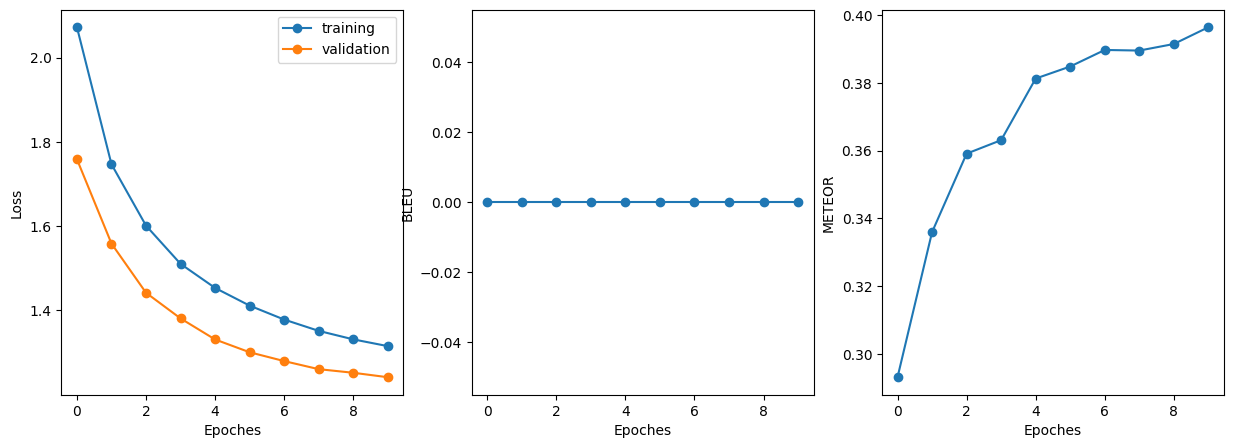

In [18]:
plot_losses()

In [19]:
bleu(examples, model, device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:287: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Input: looks like a box full of
Continuation: looks like a box full of .
Translation: it looks like a box full of `` finding your own . ''
bleu: 0.2857142984867096

Input: the fucking gun
Continuation: the gun .
Translation: drop the gun .
bleu: 0.3333333134651184

Input: i pay to watch them masturbate
Continuation: sometimes i pay them to watch them .
Translation: sometimes i only pay for looking .
bleu: 0.22062422564614886

Input: damn it , no man lives in a vacuum
Continuation: `` hell , no man lives in a vacuum !
Translation: `` hell , no one lives in a vacuum !
bleu: 0.29999998211860657

Input: , shit
Continuation: , man !
Translation: blimey !
bleu: 0.3333333134651184

Input: you any of this desert ufo lunatics
Continuation: you 're any of this desert , dr. crazy ?
Translation: y'all some of those desert ufo freaks ?
bleu: 0.09999999403953552

0.24390245974063873
